<a href="https://colab.research.google.com/github/vbipin/aip/blob/master/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#########
#Work in progress. Just a backup
#########

In [21]:
#In this we are exploring the decision tree algorithm
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [22]:
#Some util functions
from collections import Counter
def entropy( P ) :    
    #make sure that the incoming is a probability dist
    assert( abs(sum(P) - 1) < 0.0001 ) #sum(P) must be 1; sometimes because of float values it need not be exactly 1
    
    sum_all = 0
    for p in P :
        sum_all += -p * np.log2(p) #entropy is the sum of -p*log(p)
    
    return sum_all

def p_from_count( n_count ) :
    #print(n_count)
    N = sum(n_count)
    return [i/N for i in n_count]

def p_from_n_items( n_items ) :
    """count the items and build the probability distribution"""
    c = Counter(n_items)
    return p_from_count([c[i] for i in sorted(c.keys())])

def p_dict_from_n_items( n_items ) :
    """return a dict of {class: probability, ...}"""
    c = Counter(n_items)
    N = sum(c.values())
    p_dict = {label:count/N for label,count in c.items() }
    return p_dict

def entropy_from_n_items( n_items ) :
    """entropy form a list like [0,0,1,0,2,2]"""
    return entropy( p_from_n_items( n_items ) )


def data_split( X, Y, index_list ) :
    """Returns new X,Y at the indexs"""
    return X[index_list], Y[index_list] #worls only with numpy arrays



In [23]:
#we split a continuous variable according to a value in to left and right trees
#left branch is < 

def split_continuous_feature( X, feature_index, split_value ) :
    left_index = []
    right_index = []
    for i,x in enumerate(X) :
        if x[ feature_index ] < split_value :
            left_index.append(i) #we just store the index of the data points
        else :
            right_index.append(i)
    return left_index, right_index

In [24]:
#information gain

def information_gain( parent, child_list ) :
    """ parent is the list of y values
        child_list is the list of y values for each child node
    """
    parent_entropy = entropy_from_n_items(parent)
    #for expectation we need each child probability
    child_probability = [ len(c)/len(parent)      for c in child_list]
    child_entropy     = [ entropy_from_n_items(c) for c in child_list]
    children_expected_entropy = sum( [child_probability[i] * child_entropy[i] for i in range(len(child_list)) ] )
    
    return parent_entropy - children_expected_entropy

In [25]:
X = np.array([ 
    [1,1,3], 
    [2,1,5],
    [1,2,5],
    [3,1,7],
    [2,2.5,6],
    [3,3,2],
])
Y = np.array([1,1,1,1,0,0])

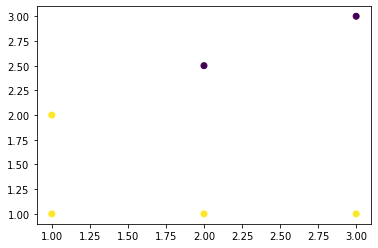

In [26]:
plt.scatter(X[:,0], X[:,1], c=Y)

In [27]:
l_index,r_index =split_continuous_feature(X, feature_index=1, split_value=2.2)
L = Y[l_index]
R = Y[r_index]
information_gain(Y,[L,R])

0.9182958340544896

In [28]:
########################################################################

In [29]:
def find_IG_of_all_splits(X, Y, feature_index) :
    """returns the IG of all the splits"""
    ig_list = []
    for split_value in X[:,feature_index] : #we split on all the values of this feature
        l_index,r_index =split_continuous_feature(X, feature_index, split_value)
        L = Y[l_index]
        R = Y[r_index]
        if len(L) and len(R) :
            ig_list.append( information_gain(Y,[L,R]) )
        else :
            if len(L) :
                ig_list.append( information_gain(Y,[L]) )
            else :
                ig_list.append( information_gain(Y,[R]) ) 
    return ig_list

In [30]:
def find_best_split(X,Y) :
    a = []
    for feature_index in range(len(X[0])) :
        ig = find_IG_of_all_splits(X,Y,feature_index)
        max_ig = max(ig)
        max_ig_index = ig.index(max_ig)
        split_value = X[:,feature_index][max_ig_index]
        a.append((max_ig,feature_index,split_value))

    return sorted(a)

In [31]:
#Tree node
class node :
    def __init__(self, feature_index, split_value, p_dict) :
        self.feature_index = feature_index
        self.split_value   = split_value
        self.p_dict        = p_dict # { class: probability }
        self.L = None  # < split_value
        self.R = None  # >= split_value

In [32]:
def build_decision_tree( PX, PY, depth) :
    if depth <= 0 : 
        return None
   
    _,f,v = find_best_split(PX,PY)[-1]
    p = p_dict_from_n_items( PY )
    tree = node( f, v, p )
    
    if len(p.keys()) <= 1 :
        return tree #we dont need to split this node
        
    l_index,r_index =split_continuous_feature(PX, feature_index=f, split_value=v)
    if len(l_index) > 0 :
        LX, LY = data_split(PX,PY,l_index)
        tree.L = build_decision_tree( LX, LY, depth-1 )
    
    if len(r_index) > 0 :   
        RX, RY = data_split(PX,PY,r_index)
        tree.R = build_decision_tree( RX, RY, depth-1 )
    
    return tree
        
        
def __prediction_from_p_dict( p_dict ) :
    mav_value = 0
    prediction = None
    for label, value in p_dict.items() :
        if value >= mav_value :
            prediction = label
            max_value = value
    return prediction

def prediction_from_p_dict( p_dict ) :
    class_labels = list(p_dict.keys())
    p =[ p_dict[c] for c in class_labels]
    return np.random.choice(class_labels, size=1, p=p)[0]

def apply_tree_node( node, x ) :
    prediction = prediction_from_p_dict(node.p_dict)
    if  len(node.p_dict.keys()) == 1 :
        return None, prediction
    
    if x[node.feature_index] < node.split_value : #left tree
        return node.L, prediction
    else :
        return node.R, prediction

def predict( node, x ) :
    """This will return the label of the data point x"""
    branch, prediction = apply_tree_node(node,x)
    if branch is None : #if leaf node
        return prediction
    #else, go down the tree
    return predict(branch, x)

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


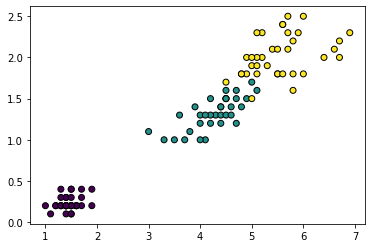

In [33]:
#############################################
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()

print(iris.data.shape)
print(iris.feature_names)
print(iris.target_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3) # 70% training and 30% test

#X = iris.data
#Y = iris.target

X=X_train
Y=y_train

plt.scatter(X[:, 2], X[:, 3],
               c=Y.astype(np.float), edgecolor='k')

In [34]:
#Work in progress. Just a backup

In [35]:
def accuracy( predicted, true ) :
    return list(predicted == true).count(True)/len(predicted)

In [37]:
tree = build_decision_tree( X, Y, 4)

In [39]:
y_ = [ predict(tree, X[i]) for i in range(len(X)) ]
accuracy(y_, y_train)

0.9523809523809523

In [38]:
t_ = [ predict(tree, X_test[i]) for i in range(len(X_test)) ]
accuracy(t_, y_test)

0.9111111111111111

In [40]:
#############################################################
#Another dataset

In [41]:
#ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
from sklearn.datasets import load_breast_cancer
b = load_breast_cancer()

print(b.data.shape)
print(b.feature_names)
print(b.target_names)

(569, 30)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


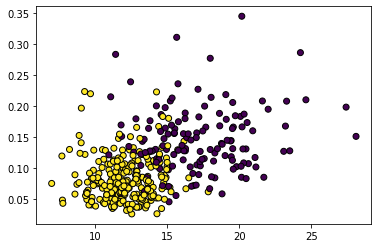

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(b.data, b.target, test_size=0.3) # 70% training and 30% test

#X = iris.data
#Y = iris.target

X=X_train
Y=y_train

plt.scatter(X[:, 0], X[:, 5],
               c=Y.astype(np.float), edgecolor='k')

In [51]:
tree = build_decision_tree( X, Y, depth=5)

y_ = [ predict(tree, X[i]) for i in range(len(X)) ]

accuracy(y_, y_train)

0.9874371859296482

In [52]:
t_ = [ predict(tree, X_test[i]) for i in range(len(X_test)) ]

accuracy(t_, y_test)

0.9298245614035088